In [1]:
import torch
import triton
import triton.language as tl


@triton.autotune(
    configs=[
        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 64}, num_warps=8, num_stages=4),
        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 64}, num_warps=4, num_stages=4),
        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 64}, num_warps=4, num_stages=2),
        triton.Config({'BLOCK_M': 64, 'BLOCK_N': 64}, num_warps=4, num_stages=2),
        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 32}, num_warps=4, num_stages=2),
        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 128}, num_warps=4, num_stages=2),




    ],
    key=['seq_len'], # The sequence length is the autotuning key
)
@triton.jit
def _flash_attention_kernel(
    Q, K, V, sm_scale,
    Out,
    stride_qz, stride_qh, stride_qm, stride_qk,
    stride_kz, stride_kh, stride_kn, stride_kk,
    stride_vz, stride_vh, stride_vn, stride_vk,
    stride_oz, stride_oh, stride_om, stride_on,
    Z, H, seq_len,
    BLOCK_M:tl.constexpr, BLOCK_N:tl.constexpr, HEAD_DIM:tl.constexpr
):

    pid_m = tl.program_id(0)
    off_z = tl.program_id(1)
    off_h = tl.program_id(2)



    # Offsets for the M dimension (rows of Q)
    offs_m = pid_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_d = tl.arange(0, HEAD_DIM)


    q_ptrs = Q \
             + (off_z * stride_qz) \
             + (off_h * stride_qh) \
             + (offs_m[:, None] * stride_qm) \
             + (offs_d[None, :] * stride_qk)   # Broadcasting: (HEAD_DIM) -> (1, HEAD_DIM)

    # Load Q block (BLOCK_M, HEAD_DIM)
    q = tl.load(q_ptrs)

    # Initialize accumulators for the "Online Softmax" algorithm
    sum_exp = tl.zeros([BLOCK_M], dtype=tl.float32)
    old_max_row = tl.full([BLOCK_M], float('-inf'), dtype=tl.float32)
    final = tl.zeros([BLOCK_M, HEAD_DIM], dtype=tl.float32)

    # Iterate by blocks along the sequence dimension N of K and V
    for start_n in tl.range(0, seq_len, BLOCK_N):

        # Hint to the compiler that start_n is aligned
        start_n = tl.multiple_of(start_n, BLOCK_N)

        # Offsets for the current K/V block
        offs_n = start_n + tl.arange(0, BLOCK_N)


        k_ptrs = K \
               + (off_z * stride_kz) \
               + (off_h * stride_kh) \
               + (offs_n[:, None] * stride_kn) \
               + (offs_d[None, :] * stride_kk)

        v_ptrs = V \
               + (off_z * stride_vz) \
               + (off_h * stride_vh) \
               + (offs_n[:, None] * stride_vn) \
               + (offs_d[None, :] * stride_vk)

        # Mask to handle sequences that are not multiples of BLOCK_N
        mask = offs_n[:, None] < seq_len

        # Load K and V: (BLOCK_N, HEAD_DIM)
        k = tl.load(k_ptrs, mask=mask, other=0.0)
        v = tl.load(v_ptrs, mask=mask, other=0.0)

        # Compute Q.Kt and scale
        attention_scores = tl.dot(q, tl.trans(k))
        attention_scores *= sm_scale

        # Local max of the current block for numerical stability
        current_max_row = tl.max(attention_scores, axis=1)

        # Update Global Max
        new_max_row = tl.maximum(old_max_row, current_max_row)

        # Alpha: Rescaling factor for previous accumulators
        # Corrects previous sums to match the new max
        alpha = tl.exp(old_max_row - new_max_row)

        # Rescaling factor for the current block
        beta = tl.exp(current_max_row - new_max_row)

        # Exponentiate current block, stabilized by local max.
        # Subtracting the max prevents overflow (NaN/Inf)
        exp_scaled = tl.exp(attention_scores - current_max_row[:, None]) * beta[:, None]

        # Update denominator (sum of exps) with alpha correction
        sum_exp = sum_exp * alpha + tl.sum(exp_scaled, 1)

        # Update numerator (accumulated attention * V) with alpha correction
        final = final * alpha[:, None] + tl.dot(exp_scaled.to(tl.float16), v)


        old_max_row = new_max_row

    # Final normalization -> Softmax applied
    final = final / sum_exp[:, None]

    O_ptrs = Out \
             + (off_z * stride_oz) \
             + (off_h * stride_oh) \
             + (offs_m[:, None] * stride_om) \
             + (offs_d[None, :] * stride_on)

    tl.store(O_ptrs, final)

def flash_attention(q, k, v, sm_scale):
    # Extract shapes: Batch, Heads, Seq_Len, Head_Dim
    Z, H, seq_len, HEAD_DIM = q.shape

    # Allocate output tensor
    o = torch.empty_like(q)

    # Define dynamic grid: X-dim scales with BLOCK_M, Y-dim collapses Batch & Heads
    grid = lambda META: (triton.cdiv(seq_len, META['BLOCK_M']), Z , H)

    _flash_attention_kernel[grid](
        q, k, v, sm_scale,
        o,
        q.stride(0), q.stride(1), q.stride(2), q.stride(3),
        k.stride(0), k.stride(1), k.stride(2), k.stride(3),
        v.stride(0), v.stride(1), v.stride(2), v.stride(3),
        o.stride(0), o.stride(1), o.stride(2), o.stride(3),
        Z, H, seq_len,
        HEAD_DIM=HEAD_DIM
    )

    return o

torch.manual_seed(0)
Z, H, seq_len, HEAD_DIM = 4, 8, 1024, 64
dtype = torch.float16

q = torch.randn((Z, H, seq_len, HEAD_DIM), dtype=dtype, device="cuda", requires_grad=False)
k = torch.randn((Z, H, seq_len, HEAD_DIM), dtype=dtype, device="cuda", requires_grad=False)
v = torch.randn((Z, H, seq_len, HEAD_DIM), dtype=dtype, device="cuda", requires_grad=False)

sm_scale = 1.0 / (HEAD_DIM ** 0.5)


ref_out = torch.nn.functional.scaled_dot_product_attention(q, k, v, scale=sm_scale)
tri_out = flash_attention(q, k, v, sm_scale=sm_scale)

print("Same shape ? ",ref_out.shape==tri_out.shape)


diff = torch.abs(ref_out - tri_out).max()
print(f"Abs diff : {diff:.6f}")



Same shape ?  True
Abs diff : 0.000244


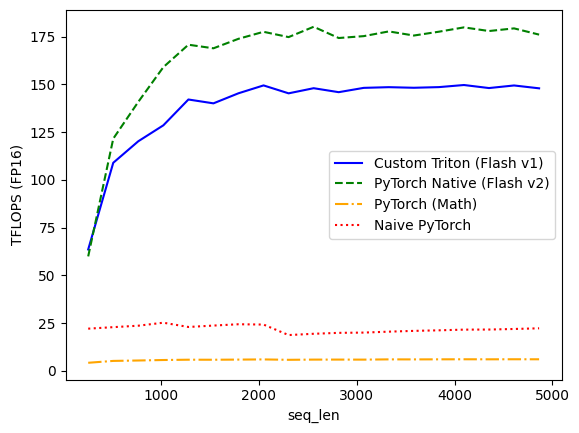

flash-attention-bench-fp16:
    seq_len  Custom Triton (Flash v1)  PyTorch Native (Flash v2)  PyTorch (Math)  Naive PyTorch
0     256.0                 63.550060                  59.918627        4.202709      22.075284
1     512.0                108.942965                 121.574026        5.181351      22.857242
2     768.0                120.218903                 140.853491        5.398847      23.622489
3    1024.0                128.561038                 159.025740        5.652701      25.191015
4    1280.0                142.083474                 170.777845        5.812828      22.954817
5    1536.0                140.069529                 168.898148        5.795461      23.689197
6    1792.0                145.347162                 173.875541        5.873368      24.382595
7    2048.0                149.462944                 177.536679        5.962053      24.213914
8    2304.0                145.311637                 174.762665        5.757696      18.716319
9    2560.0 

<Figure size 640x480 with 0 Axes>

In [2]:
import torch
import torch.nn.functional as F
from torch.nn.attention import sdpa_kernel, SDPBackend
import triton
import triton.testing
from collections import defaultdict


accuracy_stats = defaultdict(list)

# Naive implementation for reference
def naive_attention(q, k, v, sm_scale):
    # q, k, v: (B, H, seq_len, D)
    scores = torch.matmul(q, k.transpose(-2, -1)) * sm_scale
    probs = torch.softmax(scores, dim=-1)
    return torch.matmul(probs, v)

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],
        x_vals=[256 * i for i in range(1, 20)],
        line_arg='provider',
        line_vals=['triton', 'torch-native', 'torch-math', 'naive'],
        line_names=['Custom Triton (Flash v1)', 'PyTorch Native (Flash v2)', 'PyTorch (Math)', 'Naive PyTorch'],
        styles=[('blue', '-'), ('green', '--'), ('orange', '-.'), ('red', ':')],
        ylabel='TFLOPS (FP16)',
        plot_name='flash-attention-bench-fp16',
        args={'BATCH': 8, 'H': 16, 'HEAD_DIM': 64},
    )
)
def benchmark(BATCH, H, seq_len, HEAD_DIM, provider):
    dtype = torch.float16
    device = 'cuda'

    # Initialize tensors
    q = torch.randn((BATCH, H, seq_len, HEAD_DIM), device=device, dtype=dtype)
    k = torch.randn((BATCH, H, seq_len, HEAD_DIM), device=device, dtype=dtype)
    v = torch.randn((BATCH, H, seq_len, HEAD_DIM), device=device, dtype=dtype)
    sm_scale = 1.0 / (HEAD_DIM ** 0.5)

    # Select implementation
    if provider == 'triton':
        fn = lambda: flash_attention(q, k, v, sm_scale=sm_scale)
    elif provider == 'torch-native':
        fn = lambda: F.scaled_dot_product_attention(q, k, v, scale=sm_scale)
    elif provider == 'torch-math':
        def run_math():
            with sdpa_kernel([SDPBackend.MATH]):
                return F.scaled_dot_product_attention(q, k, v, scale=sm_scale)
        fn = run_math
    elif provider == 'naive':
        fn = lambda: naive_attention(q, k, v, sm_scale)
    else:
        raise ValueError(f"Unknown provider: {provider}")

    # --- Accuracy Check ---

    # Ground truth (PyTorch Native)
    ref_out = F.scaled_dot_product_attention(q, k, v, scale=sm_scale)

    # Run tested function
    out = fn()

    # Check shape
    assert out.shape == ref_out.shape, f"Shape mismatch for {provider}!"

    # Check values (Max Absolute Difference)
    diff = (out - ref_out).abs().max().item()
    accuracy_stats[provider].append(diff)


    # --- Performance Benchmarking ---

    quantiles = [0.5, 0.2, 0.8]
    ms, min_ms, max_ms = triton.testing.do_bench(fn, quantiles=quantiles)

    # Compute TFLOPS (4 ops per element)
    flops = 4 * BATCH * H * seq_len * seq_len * HEAD_DIM
    perf_tflops = flops / (ms * 1e-3) / 1e12

    return perf_tflops


benchmark.run(show_plots=True, print_data=True, save_path='.')

# Print Accuracy Report
print("\n" + "="*40)
print(f"{'Provider':<25} | {'Avg Abs Diff (vs Ref)':<20}")
print("-" * 45)
for provider, diffs in accuracy_stats.items():
    avg_diff = sum(diffs) / len(diffs) if diffs else 0.0
    print(f"{provider:<25} | {avg_diff:.6f}")
print("="*40)